<a href="https://colab.research.google.com/github/junting-huang/df4a_project/blob/main/regression_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Preprocessing

##0.1 Data Cleaning

In [ ]:
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
# read all dataframes
df_hospital = pd.read_csv('df_hospital_clean.csv')
df_price = pd.read_csv('df_price_clean.csv')
df_pop = pd.read_csv('df_population.csv')
  
# merge all three dataframes
df = pd.merge(df_hospital, df_price, on="hospital_name", how = 'inner')
df = pd.merge(df, df_pop, on="county_name", how = "inner")
  
# correct datatype
df['zip_code'] = df['zip_code'].astype('string')
df['cpt_code'] = df['cpt_code'].astype('string')
df['pcp_ratio'] = df['pcp_ratio'].astype('float')

In [ ]:
# select variables
df = df[['cash_price','capacity','revenue','tps_score','pop_density','household_income',
         'unemployment','sex_ratio','children_percent','senior_percent','white_percent',
         'high_school','pcp_ratio','life_exp','uninsured','cpt_code','urban','ownership',
         'system','hospital_name']]

# create the dataframe primary key
df = df.reset_index()
df = df.rename(columns={'index':'price_id'})
df['price_id'] = df['price_id'].astype('string')
df_dash = df

# transforms cpt code to a categorical variable 
service_cat = {'45378':'surgery','59409':'surgery','70450':'high-end test','70551':'high-end test',
               '85025':'low-end test','85027':'low-end test','99203':'visit'}
df['service_cat']= df['cpt_code'].map(service_cat)

# drop n.a. variables
df = df.dropna()
df_copy = df
df = df.drop(['urban','ownership','system','hospital_name','service_cat'],axis=1)

## 0.2 Feature Scaling


In [ ]:
# create the new dataframes based on the cpt codes 
df_colon = df.loc[df['cpt_code']== '45378']
df_delivery = df.loc[df['cpt_code'] == '59409']
df_headCT = df.loc[df['cpt_code'] == '70450']
df_brainMRI = df.loc[df['cpt_code'] == '70551']
df_bloodCount = df.loc[df['cpt_code'] == '85025']
df_bloodCountDiff = df.loc[df['cpt_code'] == '85027']
df_visit = df.loc[df['cpt_code'] == '99203']

ls_cpt = [df_colon, df_delivery, df_headCT, df_brainMRI, df_bloodCount, df_bloodCountDiff, df_visit]

In [ ]:
# normalization or standardization in order to scale all procedures to a comparable range 
from sklearn.preprocessing import StandardScaler

scaler_1 = StandardScaler()
df_st = pd.DataFrame()

for i in ls_cpt:
  it = scaler_1.fit_transform(i.drop('price_id',axis=1))
  it = pd.DataFrame(data=it, columns=df.columns[1:18])
  im = pd.concat([i['price_id'].reset_index(drop=True), it.reset_index(drop=True)], axis=1)
  df_st = df_st.append(im)

df_st

,price_id,cash_price,capacity,revenue,tps_score,pop_density,household_income,unemployment,sex_ratio,children_percent,senior_percent,white_percent,high_school,pcp_ratio,life_exp,uninsured,cpt_code
0,11,0.276290,0.883871,0.613576,0.613810,-0.237640,-0.145164,-1.215592,-0.578740,0.492138,-0.875982,-0.238372,1.126136,-0.766368,0.547387,-0.856959,0.0
1,23,0.101763,0.690565,0.158453,0.033835,-0.054903,-0.680781,0.063358,-1.070014,0.723952,-0.295127,-0.732051,0.000000,-0.633707,-1.559110,-0.856959,0.0
2,36,-0.267563,0.651904,0.360007,0.268293,-0.054903,-0.680781,0.063358,-1.070014,0.723952,-0.295127,-0.732051,0.000000,-0.633707,-1.559110,-0.856959,0.0
3,48,-0.115894,0.063396,-0.238804,0.231273,0.850064,2.014870,-0.941531,-0.484264,-0.089077,-0.446332,-0.732051,1.126136,-1.093485,1.308066,-0.856959,0.0
4,55,1.177955,1.519632,0.769618,0.564450,0.850064,2.014870,-0.941531,-0.484264,-0.089077,-0.446332,-0.732051,1.126136,-1.093485,1.308066,-0.856959,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53,538,0.473358,-0.807121,-0.532377,-1.293818,-0.696202,-0.496475,0.055388,0.465258,0.657256,0.136859,0.788922,-0.995334,0.528299,0.018647,0.219529,0.0
54,554,0.473358,-0.711437,-0.523453,1.639625,-0.695675,-0.681812,1.126224,-0.113508,-0.228509,1.168398,0.781777,0.513931,-0.561735,0.319064,0.219529,0.0
55,560,0.473358,-0.807121,-0.579669,-1.293818,-0.642939,1.054504,-0.918099,0.519517,0.408135,-0.064131,0.860373,0.891247,0.842493,1.100148,-0.841526,0.0
56,566,0.473358,-0.567913,-0.600192,-1.293818,-0.713342,-0.935431,-0.334007,0.429085,0.359404,0.552416,0.846083,-0.618018,1.747824,-0.101520,1.280583,0.0


## 0.3 Dummy Variables (Categorical Features)

In [ ]:
# create dummy variables
df_copycat = df_copy.sort_values(by=['cpt_code','price_id'])
cat_variables = df_copycat[['ownership', 'service_cat']]
cat_dummies = pd.get_dummies(cat_variables)
df_cat = pd.concat([df_st.reset_index(drop=True), cat_dummies.reset_index(drop=True)], axis=1)

df_cat

,price_id,cash_price,capacity,revenue,tps_score,pop_density,household_income,unemployment,sex_ratio,children_percent,senior_percent,white_percent,high_school,pcp_ratio,life_exp,uninsured,cpt_code,"ownership_Governmental, County","ownership_Governmental, Other","ownership_Proprietary, Corporation","ownership_Voluntary Nonprofit, Church","ownership_Voluntary Nonprofit, Other",service_cat_high-end test,service_cat_low-end test,service_cat_surgery,service_cat_visit
0,11,0.276290,0.883871,0.613576,0.613810,-0.237640,-0.145164,-1.215592,-0.578740,0.492138,-0.875982,-0.238372,1.126136,-0.766368,0.547387,-0.856959,0.0,0,0,0,0,1,0,0,1,0
1,23,0.101763,0.690565,0.158453,0.033835,-0.054903,-0.680781,0.063358,-1.070014,0.723952,-0.295127,-0.732051,0.000000,-0.633707,-1.559110,-0.856959,0.0,0,0,0,0,1,0,0,1,0
2,36,-0.267563,0.651904,0.360007,0.268293,-0.054903,-0.680781,0.063358,-1.070014,0.723952,-0.295127,-0.732051,0.000000,-0.633707,-1.559110,-0.856959,0.0,0,0,0,0,1,0,0,1,0
3,48,-0.115894,0.063396,-0.238804,0.231273,0.850064,2.014870,-0.941531,-0.484264,-0.089077,-0.446332,-0.732051,1.126136,-1.093485,1.308066,-0.856959,0.0,0,0,0,0,1,0,0,1,0
4,55,1.177955,1.519632,0.769618,0.564450,0.850064,2.014870,-0.941531,-0.484264,-0.089077,-0.446332,-0.732051,1.126136,-1.093485,1.308066,-0.856959,0.0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472,538,0.473358,-0.807121,-0.532377,-1.293818,-0.696202,-0.496475,0.055388,0.465258,0.657256,0.136859,0.788922,-0.995334,0.528299,0.018647,0.219529,0.0,0,0,0,0,1,0,0,0,1
473,554,0.473358,-0.711437,-0.523453,1.639625,-0.695675,-0.681812,1.126224,-0.113508,-0.228509,1.168398,0.781777,0.513931,-0.561735,0.319064,0.219529,0.0,0,0,0,0,1,0,0,0,1
474,560,0.473358,-0.807121,-0.579669,-1.293818,-0.642939,1.054504,-0.918099,0.519517,0.408135,-0.064131,0.860373,0.891247,0.842493,1.100148,-0.841526,0.0,0,0,0,0,1,0,0,0,1
475,566,0.473358,-0.567913,-0.600192,-1.293818,-0.713342,-0.935431,-0.334007,0.429085,0.359404,0.552416,0.846083,-0.618018,1.747824,-0.101520,1.280583,0.0,0,0,0,0,1,0,0,0,1


## 0.4 Correlation Matrix

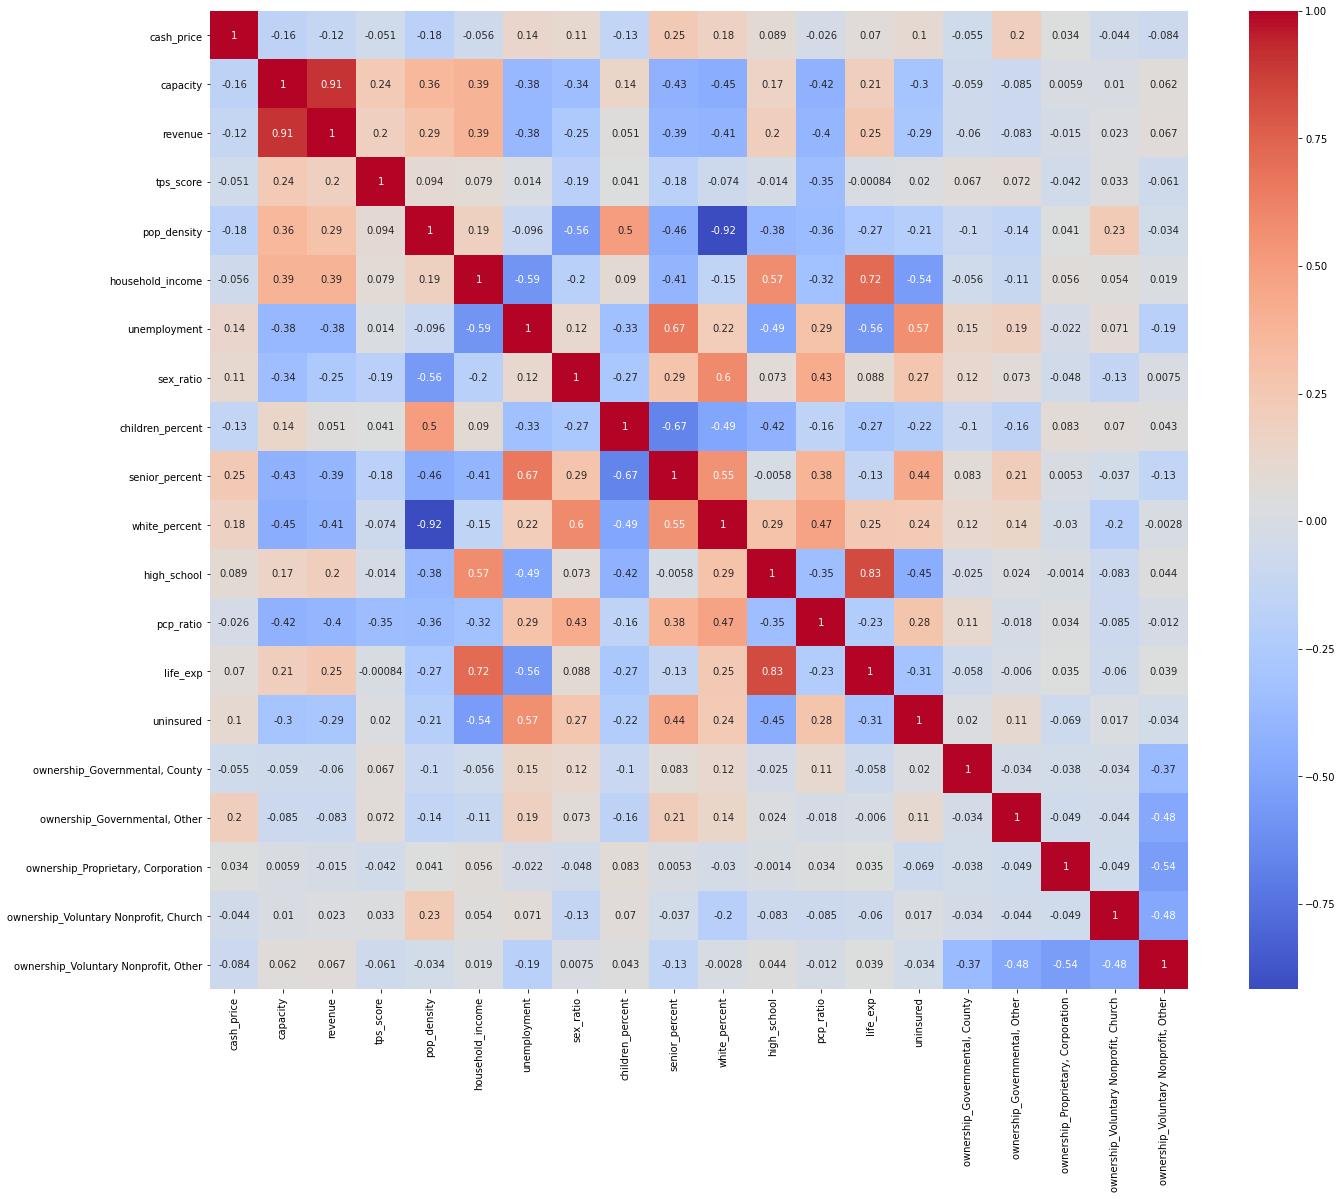

In [ ]:
# Correlation matrix (change the dataframe)
corr_mat=df_cat.drop(['service_cat_high-end test','service_cat_low-end test','service_cat_surgery','service_cat_visit','cpt_code'],axis=1).corr(method='pearson')
plt.figure(figsize=(22,18))
sns.heatmap(corr_mat,vmax=1,square=True,annot=True,cmap='coolwarm')

## 0.5 PCA (Principal component analysis)

In [ ]:
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

X = df_cat.drop(['cash_price','price_id'], axis=1)
y_new = df_cat['cash_price']

pca = PCA(n_components=2)
components = pca.fit_transform(X)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

fig = px.scatter(components, x=0, y=1, color=y_new)

for i, feature in enumerate(X.columns):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1]
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )
fig.show()

#1. Regression Models

## 1.1 Preliminary Model Selection


In [ ]:
from sklearn import datasets, linear_model
from sklearn import linear_model
from sklearn import neighbors
from sklearn import svm
from sklearn import tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor

In [ ]:
# regression model list
regr_list ={'Linear Regression': linear_model.LinearRegression(),
            'Bayesian Regression': linear_model.BayesianRidge(),
            'Least Angle Regression': linear_model.Lars(),
            'Stochastic Gradient Descent': SGDRegressor(),
            'K-Nearest Neighbors': neighbors.KNeighborsRegressor(),
            'Support Vector Machine': svm.SVR(),
            'Decision Tree': tree.DecisionTreeRegressor(),
            'Random Forest': RandomForestRegressor(),
            'Neural Network': MLPRegressor()}

In [ ]:
# X is the variables, y is the target (change the variables, or the dataframe below for cpt-code-specific results) 
X = df_cat.drop('cash_price', axis=1)
y = df_cat['cash_price']

# split the targets into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

for i in regr_list:
  regr = regr_list[i]
  regr.fit(X_train, y_train)
  y_pred = regr.predict(X_test)

  score_1 = r2_score(y_test, y_pred)
  score_2 = mean_absolute_error(y_test, y_pred)
  score_3 = mean_squared_error(y_test, y_pred)

  print(f" {i} \n the r2_score is {score_1},\n the mean_absolute_error is {score_2} ,\n the mean_squared_error is {score_3}." )
  print()

 Linear Regression 
 the r2_score is 0.11361077683164944,
 the mean_absolute_error is 0.7531478405109646 ,
 the mean_squared_error is 0.9829159385956672.

 Bayesian Regression 
 the r2_score is 0.062199653962176416,
 the mean_absolute_error is 0.7875825424010422 ,
 the mean_squared_error is 1.0399256706283722.

 Least Angle Regression 
 the r2_score is 0.117317355970733,
 the mean_absolute_error is 0.7515591723025289 ,
 the mean_squared_error is 0.9788057174667947.

 Stochastic Gradient Descent 
 the r2_score is -1.1464629122965068e+27,
 the mean_absolute_error is 30982412436205.363 ,
 the mean_squared_error is 1.2713113382370364e+27.

 K-Nearest Neighbors 
 the r2_score is 0.2582913269037258,
 the mean_absolute_error is 0.6374665526410865 ,
 the mean_squared_error is 0.8224798514303533.

 Support Vector Machine 
 the r2_score is 0.013462992238781779,
 the mean_absolute_error is 0.7349841047892305 ,
 the mean_squared_error is 1.0939696959275962.

 Decision Tree 
 the r2_score is 0.2063

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=9.874e-05, with an active set of 22 regressors, and the smallest cholesky pivot element being 9.186e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=9.884e-06, with an active set of 22 regressors, and the smallest cholesky pivot element being 6.409e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)


 Random Forest 
 the r2_score is 0.4423228272167661,
 the mean_absolute_error is 0.5538699205565092 ,
 the mean_squared_error is 0.6184075430884397.

 Neural Network 
 the r2_score is 0.05431799139467752,
 the mean_absolute_error is 0.736648201927717 ,
 the mean_squared_error is 1.048665636726489.



## 1.2 K-Fold Cross-Validation

In [ ]:
regr_shortlist ={'Linear Regression': linear_model.LinearRegression(),
            'Support Vector Machine': svm.SVR(),
            'K-Nearest Neighbors': neighbors.KNeighborsRegressor(),
            'Random Forest': RandomForestRegressor(),
            'Neural Network': MLPRegressor()}

def get_r2 (model, X_train, X_test, y_train, y_test):
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  return r2_score(y_test, y_pred)

In [ ]:
from sklearn.model_selection import KFold

lr_score = []
br_score = []
knn_score = []
rf_score = []
nn_score = []

# change the number of folds here, 5 or 10 are common
kf = KFold(n_splits=10)
for train, test in kf.split(df_cat):
  X_train, X_test, y_train, y_test = X.loc[train], X.loc[test], y.loc[train], y.loc[test]

  lr_score.append(get_r2(linear_model.LinearRegression(), X_train, X_test, y_train, y_test))
  br_score.append(get_r2(linear_model.BayesianRidge(), X_train, X_test, y_train, y_test))
  knn_score.append(get_r2(neighbors.KNeighborsRegressor(), X_train, X_test, y_train, y_test))
  rf_score.append(get_r2(RandomForestRegressor(), X_train, X_test, y_train, y_test))
  nn_score.append(get_r2(MLPRegressor(), X_train, X_test, y_train, y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
# r2 results
lr_av = sum(lr_score)/len(lr_score)
br_av = sum(br_score)/len(br_score)
knn_av = sum(knn_score)/len(knn_score)
rf_av = sum(rf_score)/len(rf_score)
nn_av = sum(nn_score)/len(nn_score)

print('R Squared With K-Fold Cross-Validation')
print(f'Linear Regression Average: {lr_av}')
print(f'Support Vector Machine: {br_av}')
print(f'Nearest Neighbors Average: {knn_av}')
print(f'Random Forest Average: {rf_av}')
print(f'Neural Network Average: {nn_av}')

R Squared With K-Fold Cross-Validation
Linear Regression Average: 0.07547678187677859
Support Vector Machine: 0.06667921393632997
Nearest Neighbors Average: 0.31161114773956045
Random Forest Average: 0.4154349988453495
Neural Network Average: 0.0995069182551505


## 1.3 Model Optimization

Hyperparameter Tuning the Random Forest

* n_estimators = number of trees in the foreset
* max_features = max number of features considered for splitting a node
* max_depth = max number of levels in each decision tree
* min_samples_split = min number of data points placed in a node before the node is split
* min_samples_leaf = min number of data points allowed in a leaf node
* bootstrap = method for sampling data points (with or without replacement)




**Accuracy Rate = 1 - Absolute Mean Error / (Mean Cash Price - Min Cash Price)**

In [ ]:
# Avarage Cash Price - Min Cash Price
y_exp = np.mean(y)
y_min = np.min(y)
y_exp - y_min

1.7206966095412397

### 1.3.1 Randomized Search 


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X, y)

In [ ]:
rf_random.best_params_

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)
    mape = 100 * (np.mean(abs(errors / 1.7206966095412397)))
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    print()
    
    return accuracy

base_model = RandomForestRegressor()
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * abs(random_accuracy - base_accuracy) / abs(base_accuracy)))

### 1.3.2 Grid Search


In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [100],
    'max_features': [2],
    'min_samples_leaf': [1],
    'min_samples_split': [3],
    'n_estimators': [1000, 1400]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
grid_search.fit(X, y)
grid_search.best_params_

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    9.7s finished


{'bootstrap': False,
 'max_depth': 100,
 'max_features': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 1000}

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)
    mape = 100 * (np.mean(abs(errors / 1.7206966095412397)))
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    print()
    
    return accuracy

base_model = RandomForestRegressor()
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)
print('Improvement of {:0.2f}%.'.format( 100 * abs(grid_accuracy - base_accuracy) / abs(base_accuracy)))

Model Performance
Average Error: 0.5441 degrees.
Accuracy = 68.38%.

Model Performance
Average Error: 0.0875 degrees.
Accuracy = 94.91%.

Improvement of 38.81%.


In [ ]:
# compare this with other base models
print('Linear Regression')
model_1 = linear_model.LinearRegression()
model_1.fit(X_train, y_train)
evaluate(model_1, X_test, y_test)

print('Support Vector Machine')
model_2 = svm.SVR()
model_2.fit(X_train, y_train)
evaluate(model_2,X_test, y_test)

print('KNN')
model_3 = neighbors.KNeighborsRegressor()
model_3.fit(X_train, y_train)
evaluate(model_3, X_test, y_test)

print('Neural Network')
model_4 = MLPRegressor()
model_4.fit(X_train, y_train)
evaluate(model_4, X_test, y_test)

Linear Regression
Model Performance
Average Error: 0.7076 degrees.
Accuracy = 58.88%.

Support Vector Machine
Model Performance
Average Error: 0.5768 degrees.
Accuracy = 66.48%.

KNN
Model Performance
Average Error: 0.6113 degrees.
Accuracy = 64.47%.

Neural Network
Model Performance
Average Error: 0.5988 degrees.
Accuracy = 65.20%.



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


65.2029092743396

# 2. Prediction

## 2.1 Imputation for the Missing Revenue data

In [ ]:
# revenue data missing
df_dash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price_id          590 non-null    string 
 1   cash_price        500 non-null    float64
 2   capacity          590 non-null    int64  
 3   revenue           562 non-null    float64
 4   tps_score         590 non-null    float64
 5   pop_density       590 non-null    float64
 6   household_income  590 non-null    int64  
 7   unemployment      590 non-null    float64
 8   sex_ratio         590 non-null    float64
 9   children_percent  590 non-null    float64
 10  senior_percent    590 non-null    float64
 11  white_percent     590 non-null    float64
 12  high_school       590 non-null    float64
 13  pcp_ratio         590 non-null    float64
 14  life_exp          590 non-null    float64
 15  uninsured         590 non-null    float64
 16  cpt_code          590 non-null    string 
 1

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler_2 = MinMaxScaler()

df_dash_imp = df_dash.drop(['cpt_code','urban','ownership','type','system','hospital_name','service_cat','cash_price'],axis=1)
df_dash_imp = pd.DataFrame(scaler_2.fit_transform(df_dash_imp), columns = df_dash_imp.columns)
df_dash_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price_id          590 non-null    float64
 1   capacity          590 non-null    float64
 2   revenue           562 non-null    float64
 3   tps_score         590 non-null    float64
 4   pop_density       590 non-null    float64
 5   household_income  590 non-null    float64
 6   unemployment      590 non-null    float64
 7   sex_ratio         590 non-null    float64
 8   children_percent  590 non-null    float64
 9   senior_percent    590 non-null    float64
 10  white_percent     590 non-null    float64
 11  high_school       590 non-null    float64
 12  pcp_ratio         590 non-null    float64
 13  life_exp          590 non-null    float64
 14  uninsured         590 non-null    float64
dtypes: float64(15)
memory usage: 69.3 KB


In [ ]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
df_dash_imp = pd.DataFrame(imputer.fit_transform(df_dash_imp),columns = df_dash_imp.columns)
df_dash_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price_id          590 non-null    float64
 1   capacity          590 non-null    float64
 2   revenue           590 non-null    float64
 3   tps_score         590 non-null    float64
 4   pop_density       590 non-null    float64
 5   household_income  590 non-null    float64
 6   unemployment      590 non-null    float64
 7   sex_ratio         590 non-null    float64
 8   children_percent  590 non-null    float64
 9   senior_percent    590 non-null    float64
 10  white_percent     590 non-null    float64
 11  high_school       590 non-null    float64
 12  pcp_ratio         590 non-null    float64
 13  life_exp          590 non-null    float64
 14  uninsured         590 non-null    float64
dtypes: float64(15)
memory usage: 69.3 KB


In [ ]:
df_dash_impd = scaler_2.inverse_transform(df_dash_imp)
df_dash_impd = pd.DataFrame(df_dash_impd, columns = df_dash_imp.columns)
df_dash_impd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price_id          590 non-null    float64
 1   capacity          590 non-null    float64
 2   revenue           590 non-null    float64
 3   tps_score         590 non-null    float64
 4   pop_density       590 non-null    float64
 5   household_income  590 non-null    float64
 6   unemployment      590 non-null    float64
 7   sex_ratio         590 non-null    float64
 8   children_percent  590 non-null    float64
 9   senior_percent    590 non-null    float64
 10  white_percent     590 non-null    float64
 11  high_school       590 non-null    float64
 12  pcp_ratio         590 non-null    float64
 13  life_exp          590 non-null    float64
 14  uninsured         590 non-null    float64
dtypes: float64(15)
memory usage: 69.3 KB


In [ ]:
df_dash_prep = df_dash.copy()
df_dash_prep['revenue'] = df_dash_impd['revenue'].values

In [ ]:
df_dash_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price_id          590 non-null    string 
 1   cash_price        500 non-null    float64
 2   capacity          590 non-null    int64  
 3   revenue           590 non-null    float64
 4   tps_score         590 non-null    float64
 5   pop_density       590 non-null    float64
 6   household_income  590 non-null    int64  
 7   unemployment      590 non-null    float64
 8   sex_ratio         590 non-null    float64
 9   children_percent  590 non-null    float64
 10  senior_percent    590 non-null    float64
 11  white_percent     590 non-null    float64
 12  high_school       590 non-null    float64
 13  pcp_ratio         590 non-null    float64
 14  life_exp          590 non-null    float64
 15  uninsured         590 non-null    float64
 16  cpt_code          590 non-null    string 
 1

## 2.2 DataFrame Preparation

In [ ]:
df_dash_prep = df_dash_prep.drop(['urban','ownership','type','system','hospital_name','service_cat'],axis=1)
df_dash_prep.info()

In [ ]:
# create the new dataframes based on the cpt codes 
df_dash_prep_colon = df_dash_prep.loc[df_dash_prep['cpt_code']== '45378']
df_dash_prep_delivery = df_dash_prep.loc[df_dash_prep['cpt_code'] == '59409']
df_dash_prep_headCT = df_dash_prep.loc[df_dash_prep['cpt_code'] == '70450']
df_dash_prep_brainMRI = df_dash_prep.loc[df_dash_prep['cpt_code'] == '70551']
df_dash_prep_bloodCount = df_dash_prep.loc[df_dash_prep['cpt_code'] == '85025']
df_dash_prep_bloodCountDiff = df_dash_prep.loc[df_dash_prep['cpt_code'] == '85027']
df_dash_prep_visit = df_dash_prep.loc[df_dash_prep['cpt_code'] == '99203']

ls_cpt_prep = [df_dash_prep_colon, df_dash_prep_delivery, df_dash_prep_headCT, df_dash_prep_brainMRI, df_dash_prep_bloodCount, df_dash_prep_bloodCountDiff, df_dash_prep_visit]

# create a new scaler for each cpt code 
scaler_p1 = StandardScaler()
scaler_p2 = StandardScaler()
scaler_p3 = StandardScaler()
scaler_p4 = StandardScaler()
scaler_p5 = StandardScaler()
scaler_p6 = StandardScaler()
scaler_p7 = StandardScaler()

ls_sc_prep = [scaler_p1,scaler_p2,scaler_p3,scaler_p4,scaler_p5,scaler_p6,scaler_p7]

In [ ]:
df_st_prep=pd.DataFrame()

for i in range(7):
  itp = ls_sc_prep[i].fit_transform(ls_cpt_prep[i].drop('price_id',axis=1))
  itp = pd.DataFrame(data=itp, columns=df.columns[1:18])
  imp = pd.concat([ls_cpt_prep[i]['price_id'].reset_index(drop=True), itp.reset_index(drop=True)], axis=1)
  df_st_prep = df_st_prep.append(imp)

df_st_prep

,price_id,cash_price,capacity,revenue,tps_score,pop_density,household_income,unemployment,sex_ratio,children_percent,senior_percent,white_percent,high_school,pcp_ratio,life_exp,uninsured,cpt_code
0,11,0.093100,0.939600,0.660683,0.630996,-0.263714,-0.163606,-1.227682,-0.566811,0.483950,-0.879977,-0.208691,1.130828,-0.759509,0.557778,-0.832050,0.0
1,23,-0.036379,0.743809,0.195239,0.066378,-0.085260,-0.696948,0.068750,-1.065860,0.719265,-0.284539,-0.691035,0.011308,-0.632720,-1.539186,-0.832050,0.0
2,36,-0.310377,0.704651,0.401364,0.294628,-0.085260,-0.696948,0.068750,-1.065860,0.719265,-0.284539,-0.691035,0.011308,-0.632720,-1.539186,-0.832050,0.0
3,41,1.294202,-0.866030,-0.587810,-1.231042,0.798501,1.987250,-0.949875,-0.470840,-0.106044,-0.439540,-0.691035,1.130828,-1.072146,1.315015,-0.832050,0.0
4,48,-0.197856,0.108575,-0.211027,0.258588,0.798501,1.987250,-0.949875,-0.470840,-0.106044,-0.439540,-0.691035,1.130828,-1.072146,1.315015,-0.832050,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,538,0.473358,-0.824440,-0.559624,-1.305861,-0.754512,-0.522099,0.071447,0.521106,0.622812,0.179546,0.842427,-0.940235,0.588515,0.014952,0.244600,0.0
58,554,0.473358,-0.731671,-0.550671,1.674527,-0.754007,-0.696725,1.154263,-0.064327,-0.267020,1.232640,0.835576,0.508077,-0.507860,0.304642,0.244600,0.0
59,560,0.473358,-0.824440,-0.607077,-1.305861,-0.703534,0.939244,-0.912932,0.575990,0.372547,-0.025643,0.910934,0.870156,0.904537,1.057837,-0.838628,0.0
60,566,0.473358,-0.592519,-0.627670,-1.305861,-0.770915,-0.935686,-0.322305,0.484516,0.323593,0.603787,0.897233,-0.578157,1.815134,-0.100924,1.327827,0.0


In [ ]:
# create dummy variables
df_dashcat = df_dash.sort_values(by=['cpt_code','price_id'])
cat_variables = df_dashcat[['ownership', 'service_cat']]
cat_dummies = pd.get_dummies(cat_variables)
df_cat_prep = pd.concat([df_st_prep.reset_index(drop=True), cat_dummies.reset_index(drop=True)], axis=1)
df_cat_prep

,price_id,cash_price,capacity,revenue,tps_score,pop_density,household_income,unemployment,sex_ratio,children_percent,senior_percent,white_percent,high_school,pcp_ratio,life_exp,uninsured,cpt_code,"ownership_Governmental, County","ownership_Governmental, Other","ownership_Proprietary, Corporation","ownership_Voluntary Nonprofit, Church","ownership_Voluntary Nonprofit, Other",service_cat_high-end test,service_cat_low-end test,service_cat_surgery,service_cat_visit
0,11,0.093100,0.939600,0.660683,0.630996,-0.263714,-0.163606,-1.227682,-0.566811,0.483950,-0.879977,-0.208691,1.130828,-0.759509,0.557778,-0.832050,0.0,0,0,0,0,1,0,0,1,0
1,23,-0.036379,0.743809,0.195239,0.066378,-0.085260,-0.696948,0.068750,-1.065860,0.719265,-0.284539,-0.691035,0.011308,-0.632720,-1.539186,-0.832050,0.0,0,0,0,0,1,0,0,1,0
2,36,-0.310377,0.704651,0.401364,0.294628,-0.085260,-0.696948,0.068750,-1.065860,0.719265,-0.284539,-0.691035,0.011308,-0.632720,-1.539186,-0.832050,0.0,0,0,0,0,1,0,0,1,0
3,41,1.294202,-0.866030,-0.587810,-1.231042,0.798501,1.987250,-0.949875,-0.470840,-0.106044,-0.439540,-0.691035,1.130828,-1.072146,1.315015,-0.832050,0.0,0,0,0,0,1,0,0,1,0
4,48,-0.197856,0.108575,-0.211027,0.258588,0.798501,1.987250,-0.949875,-0.470840,-0.106044,-0.439540,-0.691035,1.130828,-1.072146,1.315015,-0.832050,0.0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,538,0.473358,-0.824440,-0.559624,-1.305861,-0.754512,-0.522099,0.071447,0.521106,0.622812,0.179546,0.842427,-0.940235,0.588515,0.014952,0.244600,0.0,0,0,0,0,1,0,0,0,1
586,554,0.473358,-0.731671,-0.550671,1.674527,-0.754007,-0.696725,1.154263,-0.064327,-0.267020,1.232640,0.835576,0.508077,-0.507860,0.304642,0.244600,0.0,0,0,0,0,1,0,0,0,1
587,560,0.473358,-0.824440,-0.607077,-1.305861,-0.703534,0.939244,-0.912932,0.575990,0.372547,-0.025643,0.910934,0.870156,0.904537,1.057837,-0.838628,0.0,0,0,0,0,1,0,0,0,1
588,566,0.473358,-0.592519,-0.627670,-1.305861,-0.770915,-0.935686,-0.322305,0.484516,0.323593,0.603787,0.897233,-0.578157,1.815134,-0.100924,1.327827,0.0,0,0,0,0,1,0,0,0,1


## 2.3 Use New X for Prediction

In [ ]:
X_new = df_cat_prep.drop('cash_price', axis=1)
y_new = best_grid.predict(X_new)

In [ ]:
# add prediction to the dataframe
df_dash_final = df_cat_prep
df_dash_final['cash_price_pred'] = y_new
df_dash_final[['cash_price','cash_price_pred']]

,cash_price,cash_price_pred
0,0.093100,0.806760
1,-0.036379,0.100019
2,-0.310377,-0.244756
3,1.294202,0.983417
4,-0.197856,0.672581
...,...,...
585,0.473358,0.190386
586,0.473358,0.354315
587,0.473358,0.208316
588,0.473358,0.246641


In [ ]:
# add back cpt code and reverse transform
df_cpt_extract = df_dash.sort_values(by=['cpt_code','price_id'])['cpt_code']
df_cpt_extract = df_cpt_extract.reset_index()
df_cpt_extract = df_cpt_extract['cpt_code']
df_dash_final['cpt_code'] = df_cpt_extract

## 2.4 Inverse Transformation

In [ ]:
# replace cash with pred
df_dash_final['cash_price'] = df_dash_final['cash_price_pred']

# unify the shape of df_dash_final and df_st_prep
to_drop = set(df_dash_final.columns) - set(df_st_prep.columns)
df_dash_final = df_dash_final.drop(columns=to_drop)
df_dash_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price_id          590 non-null    string 
 1   cash_price        590 non-null    float64
 2   capacity          590 non-null    float64
 3   revenue           590 non-null    float64
 4   tps_score         590 non-null    float64
 5   pop_density       590 non-null    float64
 6   household_income  590 non-null    float64
 7   unemployment      590 non-null    float64
 8   sex_ratio         590 non-null    float64
 9   children_percent  590 non-null    float64
 10  senior_percent    590 non-null    float64
 11  white_percent     590 non-null    float64
 12  high_school       590 non-null    float64
 13  pcp_ratio         590 non-null    float64
 14  life_exp          590 non-null    float64
 15  uninsured         590 non-null    float64
 16  cpt_code          590 non-null    string 
dt

In [ ]:
df_dash_final['cpt_code'] = df_dash_final['cpt_code'].astype('float')

In [ ]:
scl = [scaler_p1, scaler_p2, scaler_p3, scaler_p4, scaler_p5, scaler_p6, scaler_p7]
final_cpt_list = df_dash_final['cpt_code'].unique()

df_inverse_final = pd.DataFrame()

for i in range(7):
  df_inverse = pd.DataFrame()
  df_inverse = df_dash_final.loc[df_dash_final['cpt_code'] == final_cpt_list[i]]
  df_inverse = scl[i].inverse_transform(df_inverse.drop('price_id',axis=1))
  df_inverse = pd.DataFrame(data=df_inverse)
  imi = pd.concat([ls_cpt_prep[i]['price_id'].reset_index(drop=True),df_inverse.reset_index(drop=True)], axis=1)
  df_inverse_final = df_inverse_final.append(imi)

df_inverse_final

,price_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,11,4566.600795,415.0,1.920000e+09,3.875000e+01,182.1,56700.0,0.028,95.7,0.179061,0.154335,82.7,0.94,42.92,79.1,0.06,90756.0
1,23,2360.724791,370.0,1.220000e+09,2.700000e+01,245.0,50600.0,0.042,93.1,0.183291,0.179691,76.4,0.91,48.33,75.5,0.06,90756.0
2,36,1284.615439,361.0,1.530000e+09,3.175000e+01,245.0,50600.0,0.042,93.1,0.183291,0.179691,76.4,0.91,48.33,75.5,0.06,90756.0
3,41,5117.978954,0.0,4.234000e+07,0.000000e+00,556.5,81300.0,0.031,96.2,0.168455,0.173091,76.4,0.94,29.58,80.4,0.06,90756.0
4,48,4147.801968,224.0,6.090000e+08,3.100000e+01,556.5,81300.0,0.031,96.2,0.168455,0.173091,76.4,0.94,29.58,80.4,0.06,90756.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,538,118.407571,25.0,2.390000e+08,3.552714e-15,22.5,51800.0,0.042,101.4,0.183606,0.197775,96.5,0.88,107.08,77.9,0.07,198406.0
58,554,126.745250,45.0,2.490000e+08,5.950000e+01,22.7,49900.0,0.053,98.2,0.167204,0.242554,96.4,0.92,57.92,78.4,0.07,198406.0
59,560,119.319517,25.0,1.860000e+08,3.552714e-15,42.7,67700.0,0.032,101.7,0.178993,0.189050,97.5,0.93,121.25,79.7,0.06,198406.0
60,566,121.268788,75.0,1.630000e+08,3.552714e-15,16.0,47300.0,0.038,101.2,0.178090,0.215814,97.3,0.89,162.08,77.7,0.08,198406.0


In [ ]:
df_inverse_final.columns = df_dash_final.columns
df_inverse_final

,price_id,cash_price,capacity,revenue,tps_score,pop_density,household_income,unemployment,sex_ratio,children_percent,senior_percent,white_percent,high_school,pcp_ratio,life_exp,uninsured,cpt_code
0,11,4566.600795,415.0,1.920000e+09,3.875000e+01,182.1,56700.0,0.028,95.7,0.179061,0.154335,82.7,0.94,42.92,79.1,0.06,90756.0
1,23,2360.724791,370.0,1.220000e+09,2.700000e+01,245.0,50600.0,0.042,93.1,0.183291,0.179691,76.4,0.91,48.33,75.5,0.06,90756.0
2,36,1284.615439,361.0,1.530000e+09,3.175000e+01,245.0,50600.0,0.042,93.1,0.183291,0.179691,76.4,0.91,48.33,75.5,0.06,90756.0
3,41,5117.978954,0.0,4.234000e+07,0.000000e+00,556.5,81300.0,0.031,96.2,0.168455,0.173091,76.4,0.94,29.58,80.4,0.06,90756.0
4,48,4147.801968,224.0,6.090000e+08,3.100000e+01,556.5,81300.0,0.031,96.2,0.168455,0.173091,76.4,0.94,29.58,80.4,0.06,90756.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,538,118.407571,25.0,2.390000e+08,3.552714e-15,22.5,51800.0,0.042,101.4,0.183606,0.197775,96.5,0.88,107.08,77.9,0.07,198406.0
58,554,126.745250,45.0,2.490000e+08,5.950000e+01,22.7,49900.0,0.053,98.2,0.167204,0.242554,96.4,0.92,57.92,78.4,0.07,198406.0
59,560,119.319517,25.0,1.860000e+08,3.552714e-15,42.7,67700.0,0.032,101.7,0.178993,0.189050,97.5,0.93,121.25,79.7,0.06,198406.0
60,566,121.268788,75.0,1.630000e+08,3.552714e-15,16.0,47300.0,0.038,101.2,0.178090,0.215814,97.3,0.89,162.08,77.7,0.08,198406.0


In [ ]:
df_inverse_final = df_inverse_final.rename(columns={'cash_price':'cash_price_pred'})

In [ ]:
df_inverse_final.to_csv('df_inverse_final.csv')

## 2.5 Create the Final Dashboard Dataframe

In [ ]:
df_dashboard = pd.read_csv('df_dashboard.csv')
df_dashboard['price_id'] = df_dashboard['price_id'].astype('string')
df_dashboard_final = pd.merge(df_dashboard, df_inverse_final[['price_id','cash_price_pred']], on='price_id', how='inner')
df_dashboard_final.to_csv('df_dashboard_final.csv')